In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
from torch.functional import F
import numpy
from d2l import torch as d2l

# 数据

In [2]:
# 数据
batch_size = 32
num_steps = 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps, use_random_iter=True)

# 模型

In [3]:
class MyGRUModel(nn.Module):
    def __init__(self, num_inputs: int, num_hiddens: int):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.W_xr = nn.Parameter(torch.normal(0, 0.01, (num_inputs, num_hiddens)))
        self.W_hr = nn.Parameter(torch.normal(0, 0.01, (num_hiddens, num_hiddens)))
        self.b_r = nn.Parameter(torch.zeros(num_hiddens))
        self.W_xz = nn.Parameter(torch.normal(0, 0.01, (num_inputs, num_hiddens)))
        self.W_hz = nn.Parameter(torch.normal(0, 0.01, (num_hiddens, num_hiddens)))
        self.b_z = nn.Parameter(torch.zeros(num_hiddens))
        self.W_xh = nn.Parameter(torch.normal(0, 0.01, (num_inputs, num_hiddens)))
        self.W_hh = nn.Parameter(torch.normal(0, 0.01, (num_hiddens, num_hiddens)))
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))
        self.W_hq = nn.Parameter(torch.normal(0, 0.01, (num_hiddens, num_inputs)))
        self.b_q = nn.Parameter(torch.zeros(num_inputs))

    def forward(self, X: torch.Tensor, H: torch.Tensor):
        # X: [batch_size, num_steps] -> [num_steps, batch_size, num_inputs]
        X = F.one_hot(X.T, self.num_inputs).type(torch.float32)
        H = H.reshape(X.shape[1], -1)
        Y = []
        for X_t in X:
            R_t = F.sigmoid(X_t @ self.W_xr + H @ self.W_hr + self.b_r)
            Z_t = F.sigmoid(X_t @ self.W_xz + H @ self.W_hz + self.b_z)
            H_tilde = F.tanh(X_t @ self.W_xh + (R_t * H) @ self.W_hh + self.b_h)
            H_t = Z_t * H + (1 - Z_t) * H_tilde
            H = H_t
            Y_t = H_t @ self.W_hq + self.b_q
            Y.append(Y_t)
        return torch.cat(Y, dim=0), H

In [11]:
class GRUModel(nn.Module):
    def __init__(self, num_inputs: int, num_hiddens: int):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.gru = nn.GRU(num_inputs, num_hiddens)
        self.linear = nn.Linear(num_hiddens, num_inputs)

    def forward(self, X, H):
        # X: [batch_size, num_steps] -> [num_steps, batch_size, num_inputs]
        X = F.one_hot(X.T, self.num_inputs).type(torch.float32)
        # Y: [num_steps, batch_size, num_hiddens] -> [num_steps * batch_size, num_hiddens]
        Y, H = self.gru(X, H)
        Y = Y.reshape(-1, self.num_hiddens)
        Y = self.linear(Y)
        return Y, H

# 训练

In [12]:
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = math.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

perplexity: 1.385965030126288, speed: 85282.96935065878 token(s)/sec


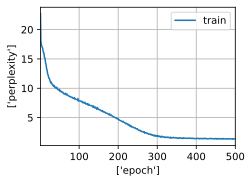

In [13]:
def train(model, train_iter, loss_fn, optimizer, num_epochs, device):
    metric = d2l.Accumulator(2)
    timer = d2l.Timer()
    animator = d2l.Animator(xlabel=['epoch'], ylabel=['perplexity'],
                            legend=['train'], xlim=[1, num_epochs])
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        metric.reset()
        timer.start()
        for X, Y in train_iter:
            # X: [batch_size, num_steps]
            # Y: [batch_size, num_steps]
            X, Y = X.to(device), Y.to(device)
            Y = Y.T.reshape(-1)
            hidden = torch.zeros((1, len(X), model.num_hiddens)).to(device)
            Y_hat, _ = model(X, hidden)
            loss = loss_fn(Y_hat, Y)
            optimizer.zero_grad()
            loss.backward()
            grad_clipping(model, 1)
            optimizer.step()
            metric.add(loss * Y.numel(), Y.numel())
        animator.add(epoch + 1, math.exp(metric[0] / metric[1]))
        print(f'perplexity: {math.exp(metric[0] / metric[1])}, speed: {metric[1] / timer.stop()} token(s)/sec')


lr = 1
num_epochs = 500

model = GRUModel(num_inputs=len(vocab), num_hiddens=256)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

train(model, train_iter, loss_fn, optimizer, num_epochs, d2l.try_gpu())

# 推理

In [14]:
def predict(model, prefix, num_preds, vocab, device):
    model.to(device)
    model.eval()
    prefix = vocab[list(prefix)]
    prefix = [torch.tensor([p]).reshape(1, 1) for p in prefix]
    hidden = torch.zeros((1, 1, model.num_hiddens)).to(device)
    for X in prefix:
        X = X.to(device)
        Y_hat, hidden = model(X, hidden)
    pred = [torch.argmax(Y_hat, dim=1, keepdim=True)]
    for _ in range(num_preds):
        Y_hat, hidden = model(pred[-1], hidden)
        pred.append(torch.argmax(Y_hat, dim=1, keepdim=True))
    pred = [vocab.idx_to_token[idx] for idx in pred]
    return pred

prefix = 'time '
pred = ''.join(predict(model, prefix, 50, vocab, d2l.try_gpu()))
print(prefix + pred)

time traveller smiled round at us then still smiling fai
